In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily
from teslakit.waves import Aggregate_WavesFamilies
from teslakit.mda import MaxDiss_Simplified_NoThreshold

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')

# MDA number of cases
nsims=2
num_sel_mda = 500

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)


In [3]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
# WVS = db.Load_WAVES_hist()

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
# Simulation

HS=[]; H1=[]; H2=[]; H3=[]
TS=[]; T1=[]; T2=[]; T3=[]
DS=[]; D1=[]; D2=[]; D3=[]
MSL=[]; WD=[]; WS=[]
MU=[]; TAU=[]; DWT=[]
HS_AG=[]; TP_AG=[]; DIR_AG=[]
TIME=[]

for a in range (nsims):
    WVS_sim, tc_sim, WVS_upd = CE.LoadSim(n_sim = a)
    WVS_upd = WVS_upd.isel(n_sim = 0)  
    WVS_agr = Aggregate_WavesFamilies(WVS_upd,a_tp='max_energy')
    HS=np.append(HS,WVS_sim.sea_Hs); H1=np.append(H1,WVS_sim.swell_1_Hs); H2=np.append(H2,WVS_sim.swell_2_Hs); H3=np.append(H3,WVS_sim.swell_3_Hs)
    TS=np.append(TS,WVS_sim.sea_Tp); T1=np.append(T1,WVS_sim.swell_1_Tp); T2=np.append(T2,WVS_sim.swell_2_Tp); T3=np.append(T3,WVS_sim.swell_3_Tp);
    DS=np.append(DS,WVS_sim.sea_Dir); D1=np.append(D1,WVS_sim.swell_1_Dir); D2=np.append(D2,WVS_sim.swell_2_Dir); D3=np.append(D3,WVS_sim.swell_3_Dir);
    MSL=np.append(MSL, WVS_sim.msl); WD=np.append(WD,WVS_sim.wind_dir);  WS=np.append(WS,WVS_sim.wind_speed); 
    MU=np.append(MU, tc_sim.mu); TAU=np.append(TAU, tc_sim.tau); DWT=np.append(DWT, WVS_sim.DWT)
    HS_AG=np.append(HS_AG, WVS_agr.Hs); TP_AG=np.append(TP_AG, WVS_agr.Tp); DIR_AG=np.append(DIR_AG, WVS_agr.Dir);
    
    delta_t=np.diff(np.append(WVS_sim.time.values.astype('datetime64[h]'), WVS_sim.time.values.astype('datetime64[h]')[-1])).astype('double')

    TIME=np.append(TIME, delta_t)
    

In [4]:
s=np.where(np.isnan(DIR_AG)==True)[0]
HS_AG[s]=np.nanmean(HS_AG)
TP_AG[s]=np.nanmean(TP_AG)
DIR_AG[s]=np.nanmean(DIR_AG)

In [5]:
# --------------------------------------
# MaxDiss classification

# subset, scalar and directional indexes
data_mda = np.column_stack((HS,H1,H2,H3,TS,T1,T2,T3,DS,D1,D2,D3,MSL,WD,WS))
ix_scalar = [0,1,2,3,4,5,6,7,12,14]
ix_directional = [8,9,10,11,13]


In [6]:
data_sim =  xr.Dataset(
    
    {
        'sea_Hs':(('storm'), data_mda[:,0]),
        'swell_1_Hs':(('storm'), data_mda[:,1]),
        'swell_2_Hs':(('storm'), data_mda[:,2]),
        'swell_3_Hs':(('storm'), data_mda[:,3]),
        'sea_Tp':(('storm'), data_mda[:,4]),
        'swell_1_Tp':(('storm'), data_mda[:,5]),
        'swell_2_Tp':(('storm'), data_mda[:,6]),
        'swell_3_Tp':(('storm'), data_mda[:,7]),
        'sea_Dir':(('storm'), data_mda[:,8]),
        'swell_1_Dir':(('storm'), data_mda[:,9]),
        'swell_2_Dir':(('storm'), data_mda[:,10]),
        'swell_3_Dir':(('storm'), data_mda[:,11]),
        'msl':(('storm'), data_mda[:,12]),
        'wind_dir':(('storm'), data_mda[:,13]),
        'wind_speed':(('storm'), data_mda[:,14]),
        'mu':(('storm'), MU),
        'tau':(('storm'), TAU),
        'dwt':(('storm'), DWT),
        'Hs':(('storm'), HS_AG),
        'Tp':(('storm'), TP_AG),
        'Dir':(('storm'), DIR_AG),
        'Time':(('storm'), TIME),
        
    },
    coords = {
        'storm':(('storm'), np.arange(len(data_mda)))    
    },
)

print(data_sim)
data_sim.to_netcdf(op.join(p_data, 'sites' ,'MAJURO-training','Dataset_'+str(nsims)+'simsmaxstorm.nc'))

<xarray.Dataset>
Dimensions:      (storm: 285199)
Coordinates:
  * storm        (storm) int64 0 1 2 3 4 ... 285194 285195 285196 285197 285198
Data variables:
    sea_Hs       (storm) float64 1.836 1.325 1.574 2.388 ... 1.334 1.25 1.262
    swell_1_Hs   (storm) float64 1.03 0.3523 0.3475 ... 0.5816 0.3349 0.2105
    swell_2_Hs   (storm) float64 1.251 0.343 0.7986 ... 1.459 1.135 0.6331
    swell_3_Hs   (storm) float64 0.5762 0.598 0.3506 ... 0.3024 0.4646 0.5844
    sea_Tp       (storm) float64 9.51 8.713 10.2 8.218 ... 10.13 10.79 9.385
    swell_1_Tp   (storm) float64 9.264 12.54 5.259 8.605 ... 9.356 11.66 9.9
    swell_2_Tp   (storm) float64 9.304 14.07 13.82 5.738 ... 7.664 9.721 9.45
    swell_3_Tp   (storm) float64 8.979 11.16 10.96 13.95 ... 9.001 10.69 8.628
    sea_Dir      (storm) float64 57.2 260.9 57.48 42.25 ... 52.34 105.1 30.64
    swell_1_Dir  (storm) float64 340.2 4.101 7.065 306.1 ... 331.8 343.4 346.8
    swell_2_Dir  (storm) float64 120.4 34.14 122.7 122.3 ... 126.

In [7]:
# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)



MaxDiss dataset: 285199 --> 500

   MDA centroids: 500/500



In [11]:
# store MDA storms - parameters 
MDA_params = xr.Dataset(
    {
        'sea_Hs':(('storm'), centroids[:,0]),
        'swell_1_Hs':(('storm'), centroids[:,1]),
        'swell_2_Hs':(('storm'), centroids[:,2]),
        'swell_3_Hs':(('storm'), centroids[:,3]),
        'sea_Tp':(('storm'), centroids[:,4]),
        'swell_1_Tp':(('storm'), centroids[:,5]),
        'swell_2_Tp':(('storm'), centroids[:,6]),
        'swell_3_Tp':(('storm'), centroids[:,7]),
        'sea_Dir':(('storm'), centroids[:,8]),
        'swell_1_Dir':(('storm'), centroids[:,9]),
        'swell_2_Dir':(('storm'), centroids[:,10]),
        'swell_3_Dir':(('storm'), centroids[:,11]),
        'msl':(('storm'), centroids[:,12]),
        'wind_dir':(('storm'), centroids[:,13]),
        'wind_speed':(('storm'), centroids[:,14]),
        
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)

MDA_params.to_netcdf(op.join(p_data, 'sites' ,'MAJURO-training','MDA_Selection_500_'+str(nsims)+'simsmaxstorm.nc'))

In [12]:
CE.Load()
HIST=CE.WVS_MS
HIST

<xarray.Dataset>
Dimensions:      (time: 5316)
Coordinates:
  * time         (time) datetime64[ns] 1980-02-04T13:00:00 ... 2018-12-30
    station      int32 ...
    longitude    float32 ...
    latitude     float32 ...
Data variables:
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    swell_3_Hs   (time) float64 ...
    swell_3_Tp   (time) float64 ...
    swell_3_Dir  (time) float64 ...
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    TC_category  (time) float64 ...
    wind_speed   (time) float32 ...
    wind_dir     (time) float32 ...
    msl          (time) float32 ...
    AWL          (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1

In [13]:
def axplot_scatter_params(ax, x_hist, y_hist, x_sim, y_sim):
    'axes scatter plot variable1 vs variable2 historical and simulated'

    # simulated params 
    ax.scatter(
        x_sim, y_sim,
        c = 'silver',
        s = 2,
    )

    # historical params 
    ax.scatter(
        x_hist, y_hist,
        c = 'purple',
        s = 1,
    )


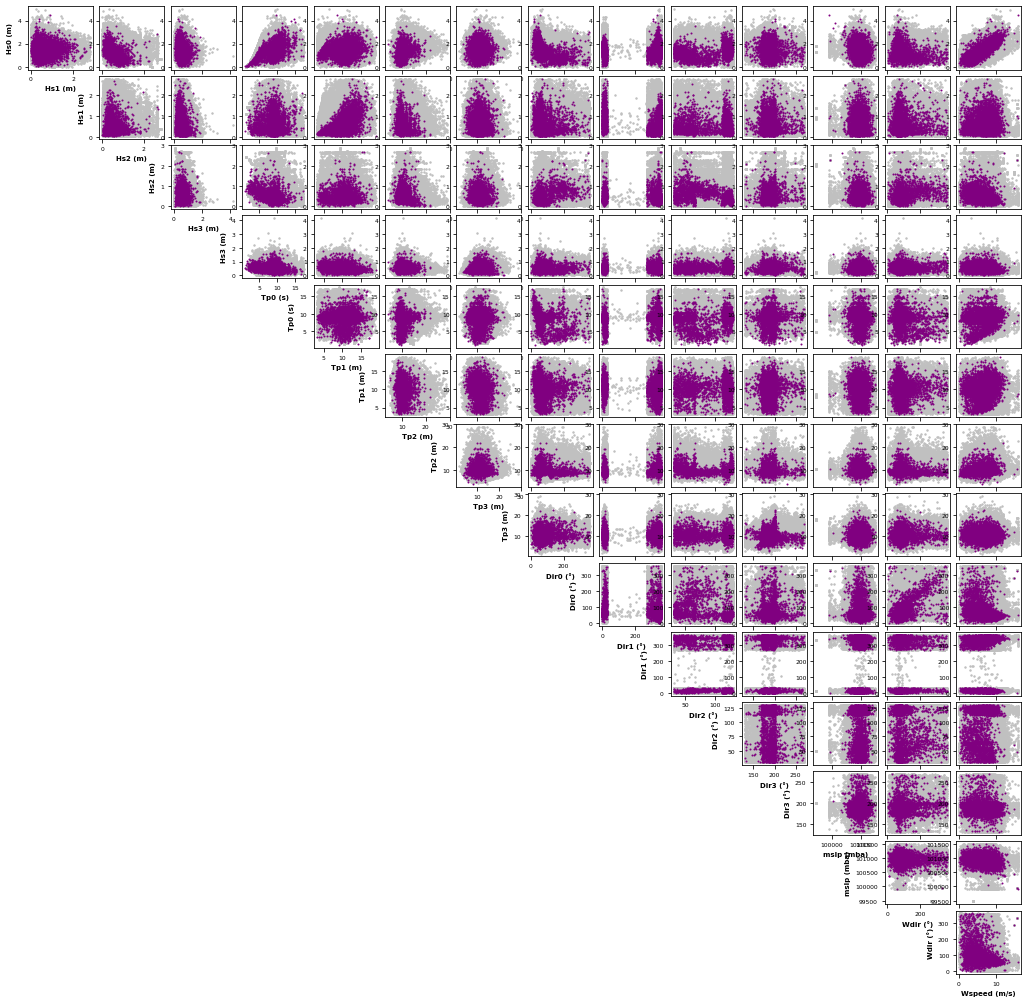

In [14]:
# common fig parameters
_faspect = 1.618
_fsize = 11
_fdpi = 128

'''
Plot scatter with historical vs simulated parameters
'''

# figure conf.
d_lab = {
    'sea_Hs': 'Hs0 (m)',
    'swell_1_Hs': 'Hs1 (m)',
    'swell_2_Hs': 'Hs2 (m)',
    'swell_3_Hs': 'Hs3 (m)',
    'sea_Tp': 'Tp0 (s)',
    'swell_1_Tp': 'Tp1 (m)',
    'swell_2_Tp': 'Tp2 (m)',
    'swell_3_Tp': 'Tp3 (m)',
    'sea_Dir': 'Dir0 (°)',
    'swell_1_Dir': 'Dir1 (°)',
    'swell_2_Dir': 'Dir2 (°)',
    'swell_3_Dir': 'Dir3 (°)',
    'msl': 'mslp (mba)',
    'wind_dir': 'Wdir (°)',
    'wind_speed': 'Wspeed (m/s)',
}

# variables to plot
vns = [ 'sea_Hs','swell_1_Hs','swell_2_Hs','swell_3_Hs','sea_Tp','swell_1_Tp','swell_2_Tp',
        'swell_3_Tp','sea_Dir','swell_1_Dir','swell_2_Dir','swell_3_Dir','msl','wind_dir','wind_speed']
n = len(vns)

# figure
fig = plt.figure(figsize=(_faspect*_fsize, _faspect*_fsize))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1)

for i in range(n):
       for j in range(i+1, n):

            # get variables to plot
            vn1 = vns[i]
            vn2 = vns[j]

            # historical and simulated
            vvh1 = HIST[vn1].values[:]
            vvh2 = HIST[vn2].values[:]

            vvs1 = data_sim[vn1].values[:]
            vvs2 = data_sim[vn2].values[:]

            # scatter plot 
            ax = plt.subplot(gs[i, j-1])
            axplot_scatter_params(ax, vvh2, vvh1, vvs2, vvs1)
            ax.tick_params(axis='both', which='major', labelsize=6)

            # custom labels
            if j==i+1:
                ax.set_xlabel(
                    d_lab[vn2],
                    {'fontsize':7, 'fontweight':'bold'}
                )
            if j==i+1:
                ax.set_ylabel(
                    d_lab[vn1],
                    {'fontsize':7, 'fontweight':'bold'}
                )

plt.show()

In [15]:
def axplot_scatter_params(ax, x_hist, y_hist, x_sim, y_sim):
    'axes scatter plot variable1 vs variable2 historical and simulated'

    # simulated params 
    ax.scatter(
        x_sim, y_sim,
        c = 'silver',
        s = 2,
    )

    # historical params 
    ax.scatter(
        x_hist, y_hist,
        c = 'royalblue',
        s = 1,
    )

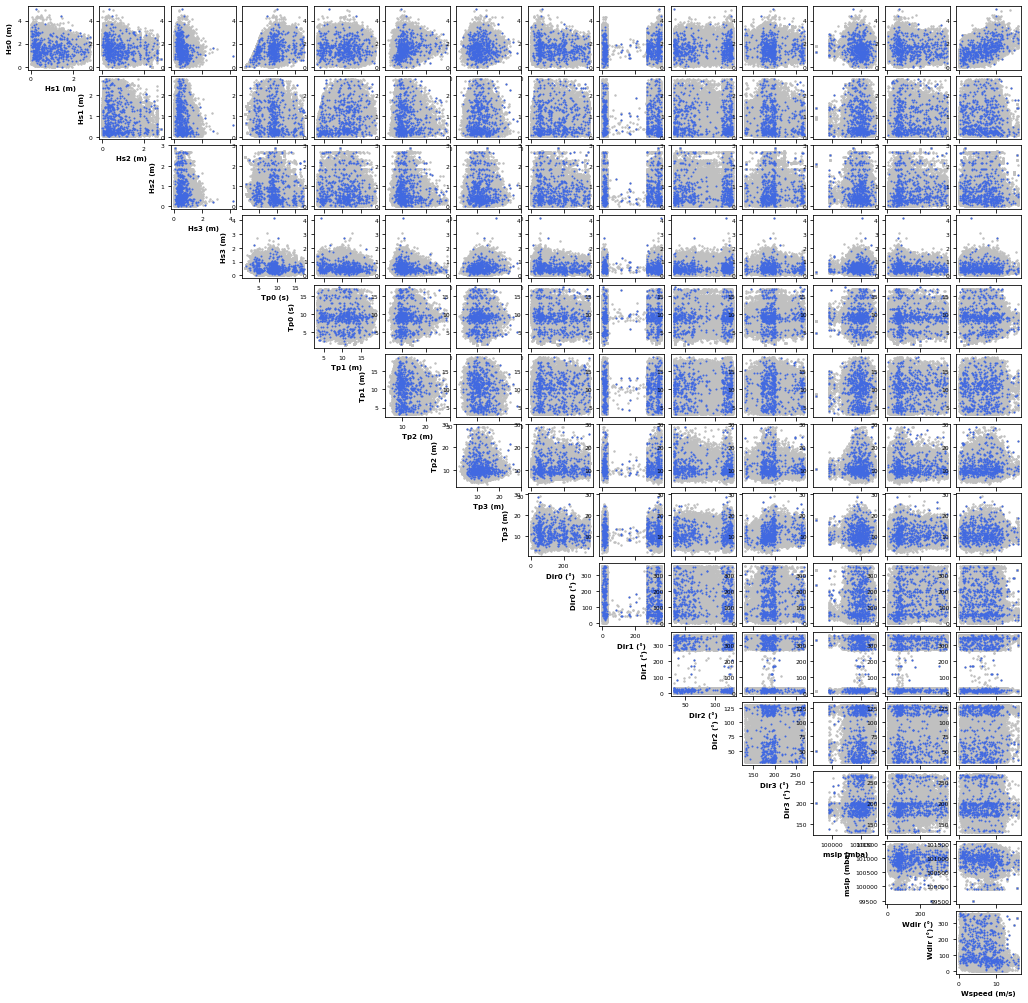

In [16]:
# common fig parameters
_faspect = 1.618
_fsize = 11
_fdpi = 128

'''
Plot scatter with historical vs simulated parameters
'''

# figure conf.
d_lab = {
    'sea_Hs': 'Hs0 (m)',
    'swell_1_Hs': 'Hs1 (m)',
    'swell_2_Hs': 'Hs2 (m)',
    'swell_3_Hs': 'Hs3 (m)',
    'sea_Tp': 'Tp0 (s)',
    'swell_1_Tp': 'Tp1 (m)',
    'swell_2_Tp': 'Tp2 (m)',
    'swell_3_Tp': 'Tp3 (m)',
    'sea_Dir': 'Dir0 (°)',
    'swell_1_Dir': 'Dir1 (°)',
    'swell_2_Dir': 'Dir2 (°)',
    'swell_3_Dir': 'Dir3 (°)',
    'msl': 'mslp (mba)',
    'wind_dir': 'Wdir (°)',
    'wind_speed': 'Wspeed (m/s)',
}

# variables to plot
vns = [ 'sea_Hs','swell_1_Hs','swell_2_Hs','swell_3_Hs','sea_Tp','swell_1_Tp','swell_2_Tp',
        'swell_3_Tp','sea_Dir','swell_1_Dir','swell_2_Dir','swell_3_Dir','msl','wind_dir','wind_speed']
n = len(vns)

# figure
fig = plt.figure(figsize=(_faspect*_fsize, _faspect*_fsize))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1)

for i in range(n):
       for j in range(i+1, n):

            # get variables to plot
            vn1 = vns[i]
            vn2 = vns[j]

            # historical and simulated
            vvh1 = MDA_params[vn1].values[:]
            vvh2 = MDA_params[vn2].values[:]

            vvs1 = data_sim[vn1].values[:]
            vvs2 = data_sim[vn2].values[:]

            # scatter plot 
            ax = plt.subplot(gs[i, j-1])
            axplot_scatter_params(ax, vvh2, vvh1, vvs2, vvs1)
            ax.tick_params(axis='both', which='major', labelsize=6)

            # custom labels
            if j==i+1:
                ax.set_xlabel(
                    d_lab[vn2],
                    {'fontsize':7, 'fontweight':'bold'}
                )
            if j==i+1:
                ax.set_ylabel(
                    d_lab[vn1],
                    {'fontsize':7, 'fontweight':'bold'}
                )

plt.show()